* **rev 01** Endogenous Models- SARIMA Failed to converge, Prophet looks promising but needs help with area around 2008 and 2020
* **rev 02** Scrape data from EIA.gov api and add Exogenous variables and continue with Prophet model.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,5)
pd.set_option('precision', 3)
pd.set_option('display.max_columns',50)
np.set_printoptions(precision=3)

In [11]:
# SARIMAX Imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [12]:
# load api key
with open('key.txt') as f:
    api_key = f.read()

## Load Data and Inspect

In [13]:
'''Data from: https://www.eia.gov/opendata/qb.php?category=371'''

root_url = f"http://api.eia.gov/series/?api_key={api_key}&series_id="

series_ids = {'NYC_No2_Oil_Price':'PET.EER_EPD2F_PF4_Y35NY_DPG.W',
             'Crude_Oil_Imports':'PET.WCRIMUS2.W',
             'Crude_Oil_Exports':'PET.WCREXUS2.W',
             'US_Fuel_Oil_Imports':'PET.WDIIMUS2.W',
             'US_Fuel_Oil_Exports':'PET.WDIEXUS2.W',
             'US_Supplied':'PET.WRPUPUS2.W'}

In [14]:
import requests
NAME,UNITS,DATA = 0,1,2
# Pull Data
series_pull = dict()
for key in series_ids.keys():
    r = requests.get(root_url + series_ids[key])
    if r.status_code == 200:
        series_pull[key] = [r.json()['series'][0]['name'],
                            r.json()['series'][0]['unitsshort'],
                            r.json()['series'][0]['data']]
        print(f'{key} - data collected successfully...')
    else:
        print(key, f': failed to collect data, status code {r.status_code}')
        
# display series info
print('\nSeries Info:')
for key in series_ids.keys():
    print(series_pull[key][NAME],series_pull[key][UNITS])

NYC_No2_Oil_Price - data collected successfully...
Crude_Oil_Imports - data collected successfully...
Crude_Oil_Exports - data collected successfully...
US_Fuel_Oil_Imports - data collected successfully...
US_Fuel_Oil_Exports - data collected successfully...
US_Supplied - data collected successfully...

Series Info:
New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly $/gal
U.S. Imports of Crude Oil, Weekly Mbbl/d
U.S. Exports of Crude Oil, Weekly Mbbl/d
U.S. Imports of Distillate Fuel Oil, Weekly Mbbl/d
U.S. Exports of Total Distillate, Weekly Mbbl/d
U.S. Product Supplied of Petroleum Products, Weekly Mbbl/d


In [15]:
df = pd.DataFrame(series_pull['NYC_No2_Oil_Price'][DATA],
                  columns=['date',series_pull['NYC_No2_Oil_Price'][NAME]])

x = list(series_pull.keys())
x.remove('NYC_No2_Oil_Price')

for weekly_series in x:
    df = df.merge(pd.DataFrame(series_pull[weekly_series][DATA],
                  columns=['date',series_pull[weekly_series][NAME]]),
                  on='date')

df['date'] = pd.to_datetime(df.date)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 0 to 600
Data columns (total 7 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   date                                                      601 non-null    datetime64[ns]
 1   New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly  601 non-null    float64       
 2   U.S. Imports of Crude Oil, Weekly                         601 non-null    int64         
 3   U.S. Exports of Crude Oil, Weekly                         601 non-null    int64         
 4   U.S. Imports of Distillate Fuel Oil, Weekly               601 non-null    int64         
 5   U.S. Exports of Total Distillate, Weekly                  601 non-null    int64         
 6   U.S. Product Supplied of Petroleum Products, Weekly       601 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
me

None

,date,"New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly","U.S. Imports of Crude Oil, Weekly","U.S. Exports of Crude Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Exports of Total Distillate, Weekly","U.S. Product Supplied of Petroleum Products, Weekly"
0,2021-12-03,1.957,6499,2270,269,1218,19837
1,2021-11-26,2.223,6604,2704,234,588,20222
2,2021-11-19,2.239,6436,2605,332,1007,21752
3,2021-11-12,2.316,6191,3626,239,849,21629
4,2021-11-05,2.337,6108,3053,278,1239,19290


In [16]:
'''Set Date to index and order in accending time'''
df.set_index('date',inplace = True)
df = df.iloc[::-1]
display(df.info())
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 601 entries, 2010-06-04 to 2021-12-03
Data columns (total 6 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly  601 non-null    float64
 1   U.S. Imports of Crude Oil, Weekly                         601 non-null    int64  
 2   U.S. Exports of Crude Oil, Weekly                         601 non-null    int64  
 3   U.S. Imports of Distillate Fuel Oil, Weekly               601 non-null    int64  
 4   U.S. Exports of Total Distillate, Weekly                  601 non-null    int64  
 5   U.S. Product Supplied of Petroleum Products, Weekly       601 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 32.9 KB


None

New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly    0
U.S. Imports of Crude Oil, Weekly                           0
U.S. Exports of Crude Oil, Weekly                           0
U.S. Imports of Distillate Fuel Oil, Weekly                 0
U.S. Exports of Total Distillate, Weekly                    0
U.S. Product Supplied of Petroleum Products, Weekly         0
dtype: int64

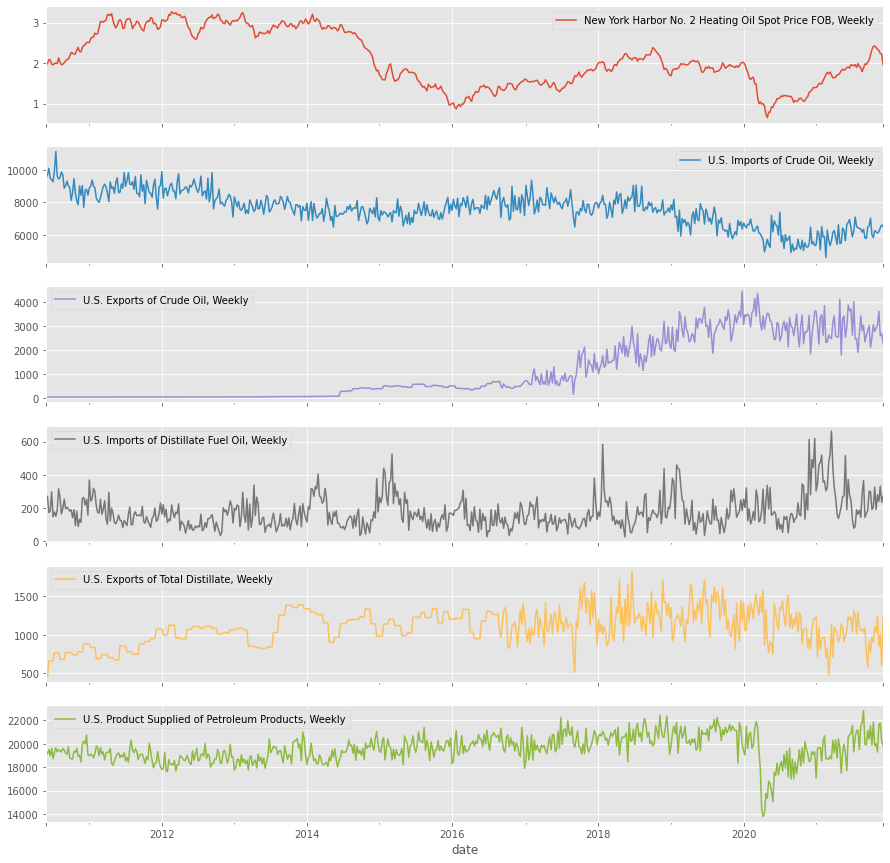

In [17]:
_=df.plot(subplots = True,legend = True, figsize = (15,15))

## Decompose

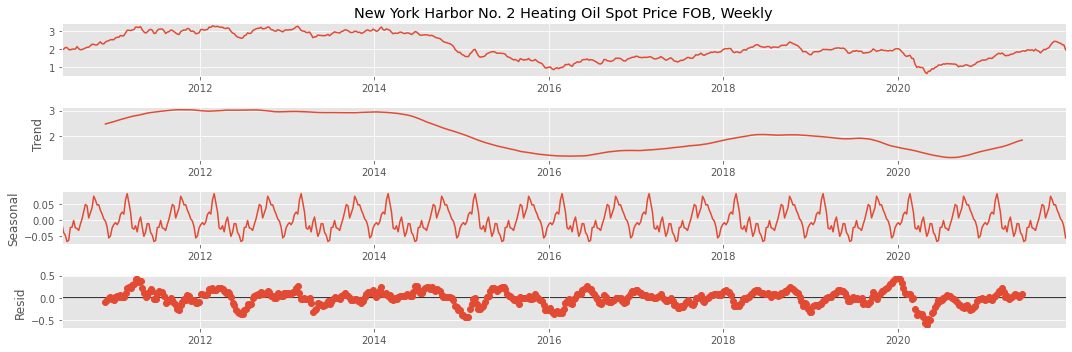

In [19]:
res = seasonal_decompose(df[df.columns[0]],model='add')
_=res.plot()

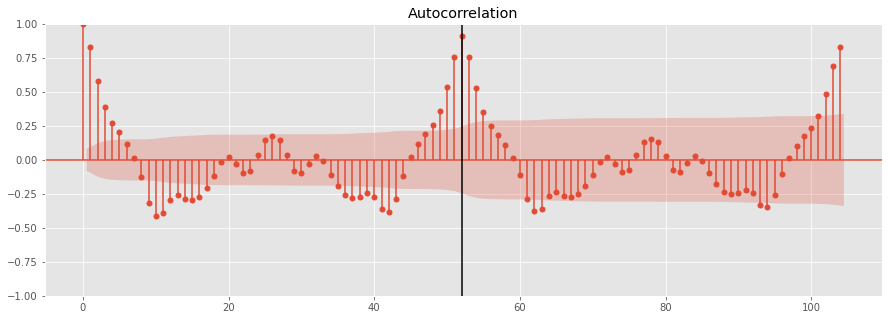

In [21]:
_=plot_acf(res.seasonal, lags=104)
_=plt.axvline(52,c='k')

## Test Train Split

In [22]:
split_idx = int(len(df)*0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]
print(f'Training Set Size {len(train_df)}')
print(f'Test Set Size {len(test_df)}')

Training Set Size 480
Test Set Size 121


## Try Prophet

In [10]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

model = Prophet()

In [14]:
ptrain_df = train_df.reset_index().rename(columns={'date':'ds','ppg':'y'})
model.fit(ptrain_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
p_forcast = model.predict(model.predict(model.make_future_dataframe(periods=162,freq='W-FRI')))

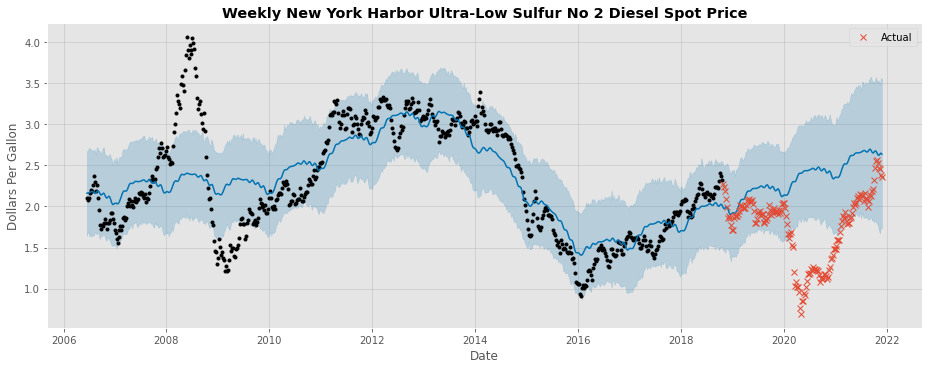

In [22]:
fig = model.plot(p_forcast,figsize=(13,5))
ax = fig.gca()
ax.plot(test_df.index,test_df.ppg,'x',label = 'Actual')
#ax.set_xlim(pd.to_datetime(['2008-01-01','2010-12-01']))
ax.legend(loc='best')
ax.set_title('Weekly New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price',
         fontweight='bold')
ax.set_ylabel('Dollars Per Gallon')
_=ax.set_xlabel('Date')